In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

**reading data**


In [3]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**removing ID**

In [4]:
data.drop("Id", axis=1, inplace=True)

**Analysing target variable (SALEPRICE)**

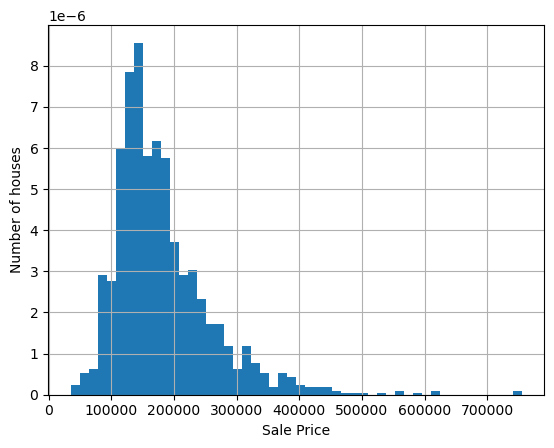

In [5]:
data["SalePrice"].hist(bins=50, density=True)
plt.ylabel("Number of houses")
plt.xlabel("Sale Price")
plt.show()

**getting all the categorical fields**

In [6]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['MSSubClass']
len(cat_vars)

44

**setting all the field type as object data type**

In [7]:
data[cat_vars] = data[cat_vars].astype('O')

**getting numerical type fields**

In [8]:
num_vars = [var for var in data.columns if var not in cat_vars and var != 'SalePrice']
len(num_vars)

35

**Missing values**

In [9]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
data[vars_with_na].isnull().mean().sort_values(ascending=False)


PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

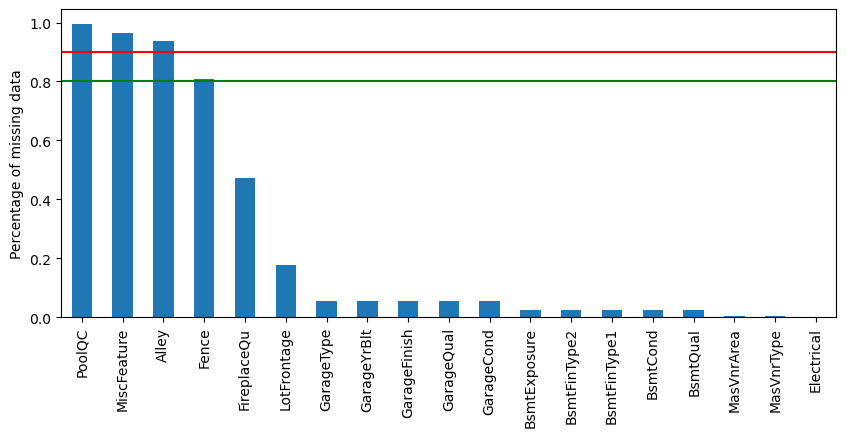

In [10]:
data[vars_with_na].isnull().mean().sort_values(ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel("Percentage of missing data")
plt.axline(xy1=(0, 0.9), slope=0, color='r', linestyle="-")
plt.axline(xy1=(0, 0.8), slope=0, color='g', linestyle="-")
plt.show()

In [11]:
cat_na = [var for var in cat_vars if var in vars_with_na]
num_na = [var for var in num_vars if var in vars_with_na]

print("number of categorical variables with na: ", len(cat_na))
print("number of numerical variables with na: ", len(num_na))

number of categorical variables with na:  16
number of numerical variables with na:  3


**relationship between missing data and target variable**

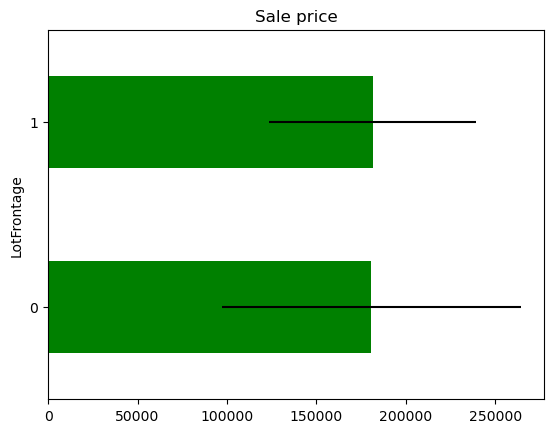

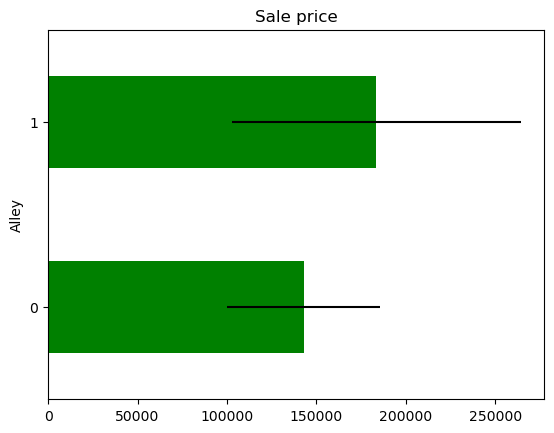

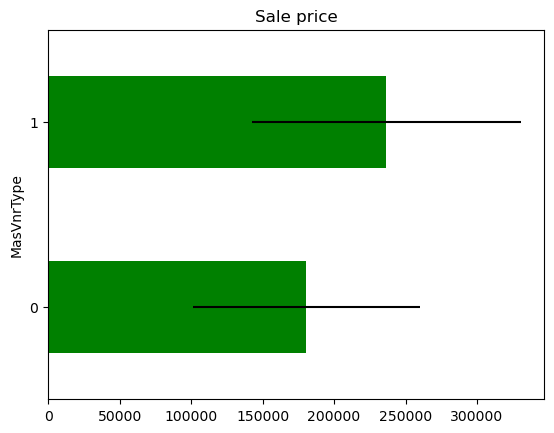

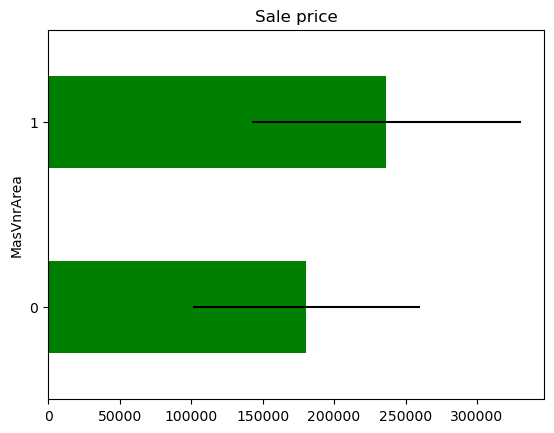

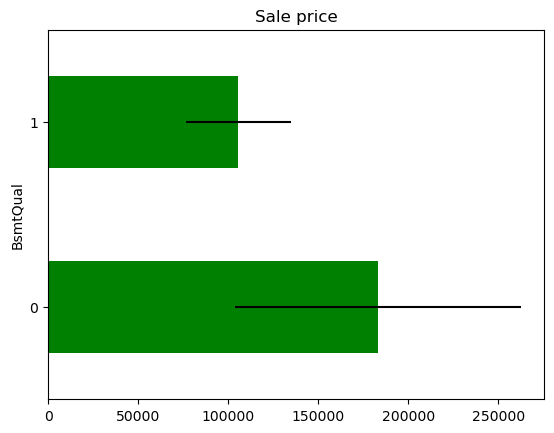

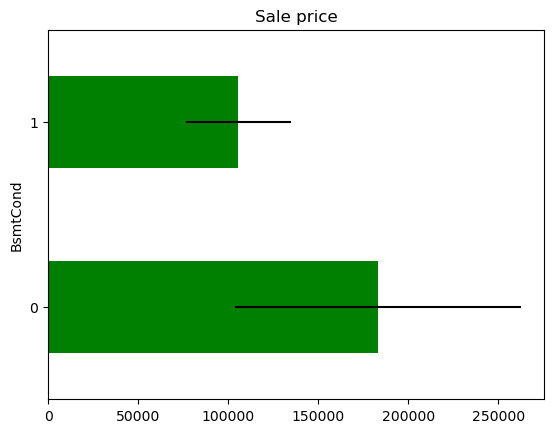

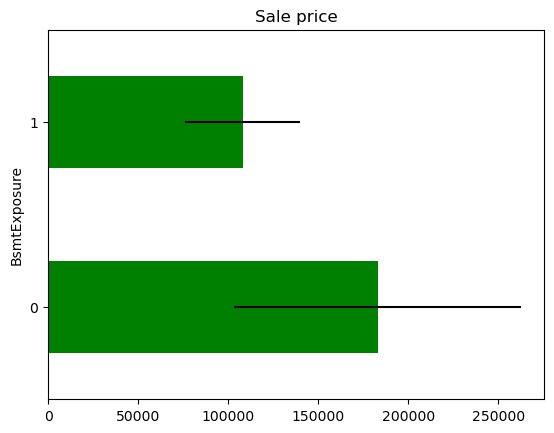

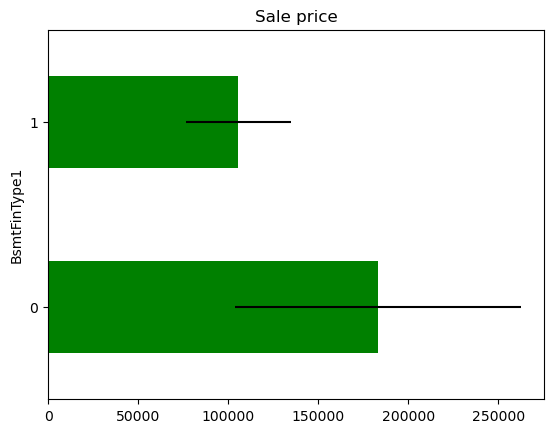

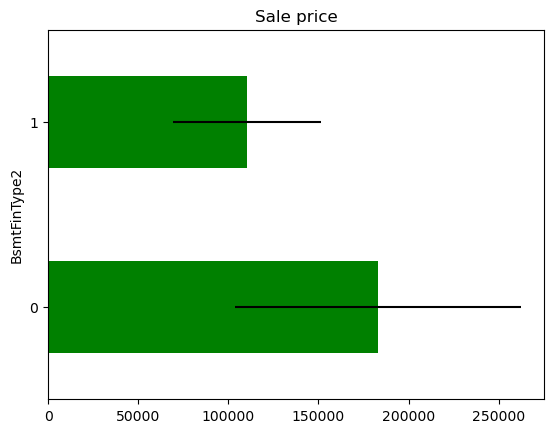

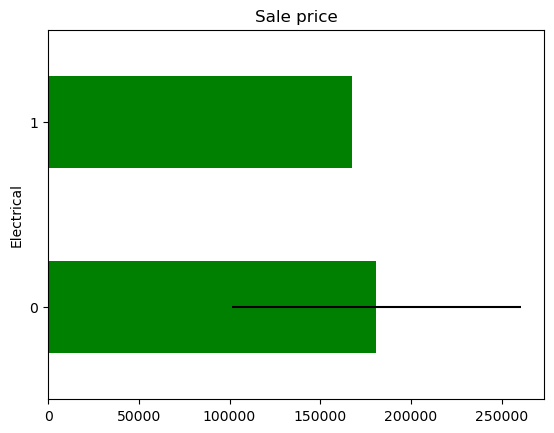

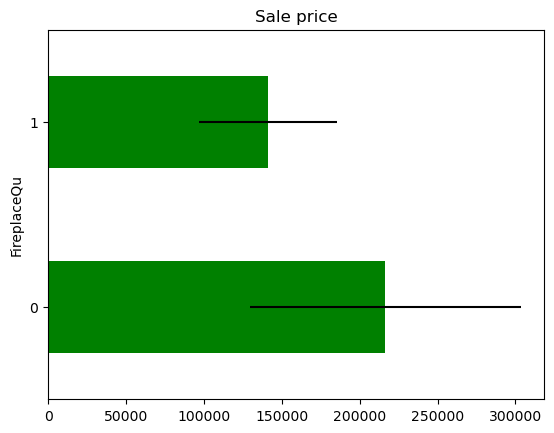

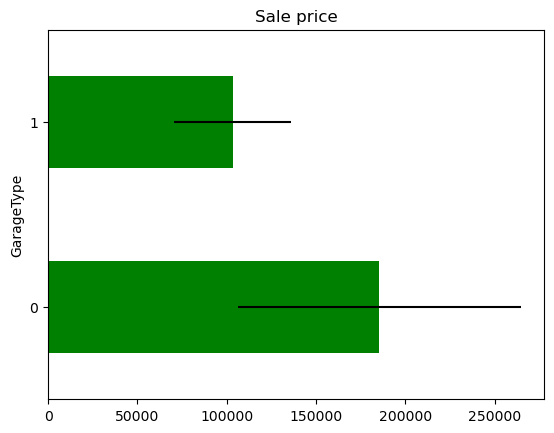

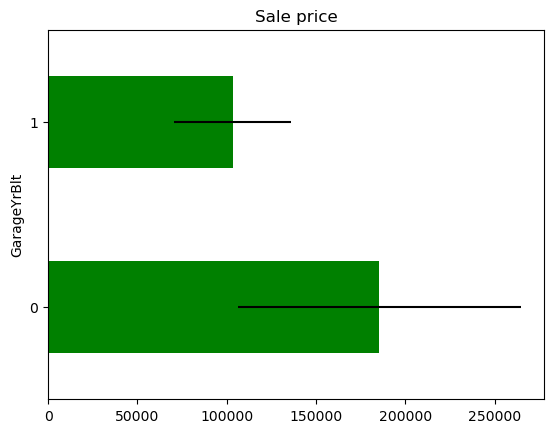

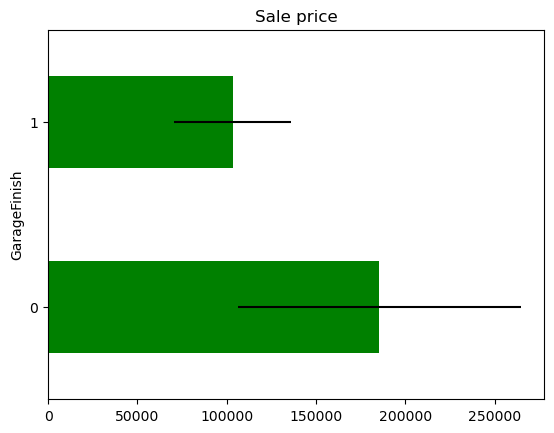

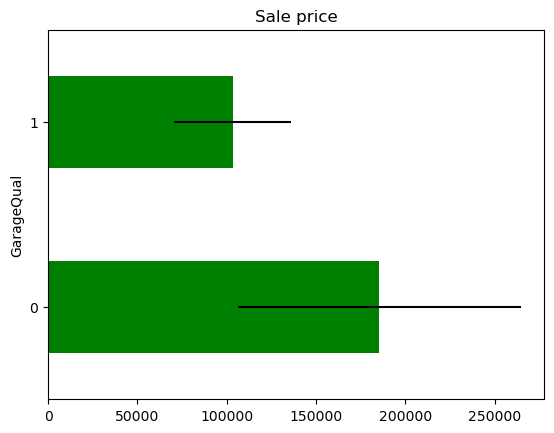

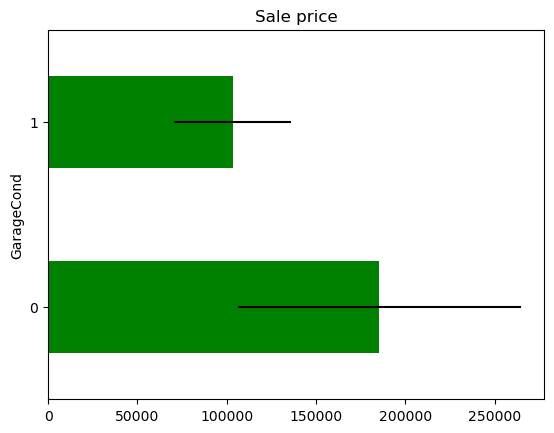

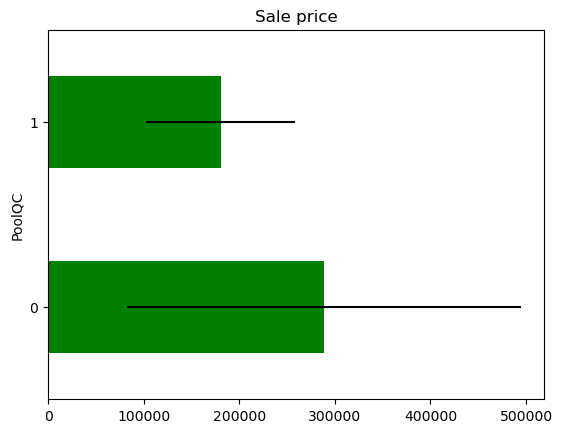

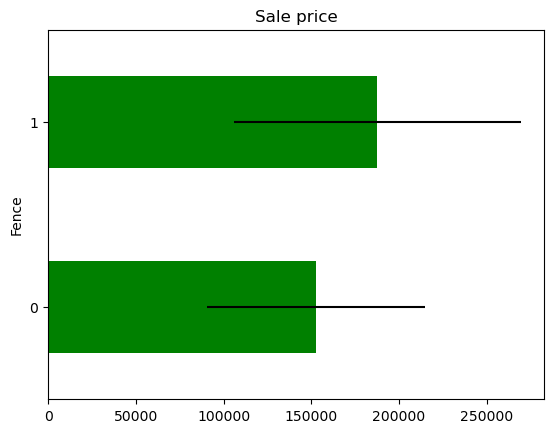

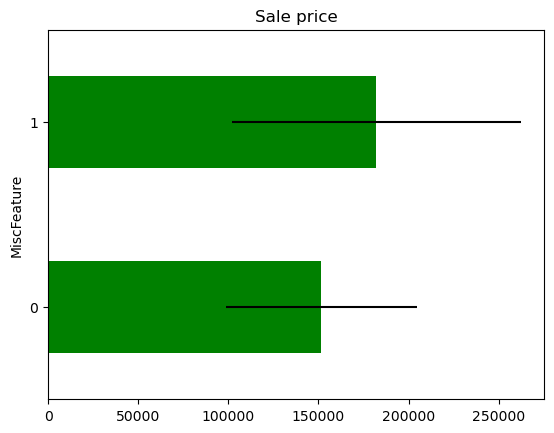

In [12]:
def analyse_na_value(df, var):
    df = df.copy()
    # an interim variable that is one if the observation
    df[var] = np.where(df[var].isnull(), 1, 0)
    tmp = df.groupby(var)["SalePrice"].agg(["mean", "std"])
    tmp.plot(kind="barh", y="mean", legend=False, xerr="std", title="Sale price", color="green")
    plt.show()
    
for var in vars_with_na:
    analyse_na_value(data, var)    

* small variation in graphs for 1 and 0 shows that missing data won't have much affect on Sale price prediction
* in case of large variation , we need to analyse deeper

In [13]:
data[num_vars].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,836,192,84,0,0,0,0,0,12,2008


**Temporal variable analysis**

In [14]:
#getting temporal fields
year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]
year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [15]:
#seggregating YrSold values 
data["YrSold"].unique()

array([2008, 2007, 2006, 2009, 2010])

Text(0, 0.5, 'Median house price')

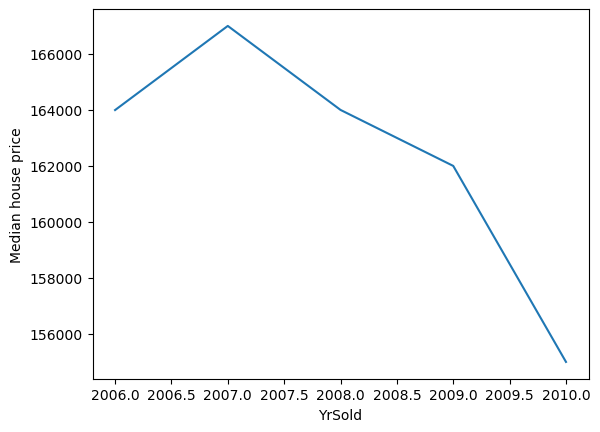

In [16]:
#plotting median values for these unique sale years
data.groupby("YrSold")["SalePrice"].median().plot()
plt.ylabel("Median house price")

Text(0, 0.5, 'Median House Price')

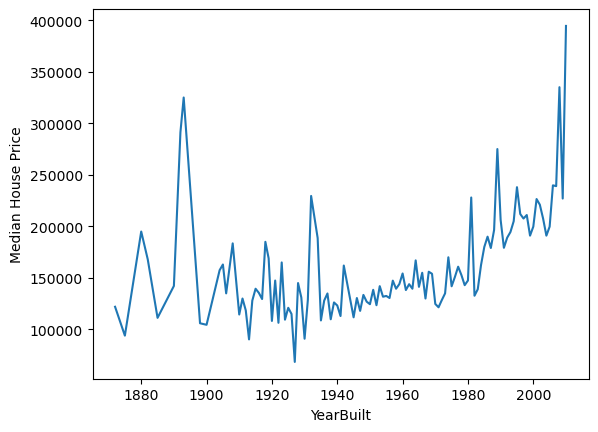

In [17]:
#similarly for YearBuilt
data.groupby('YearBuilt')['SalePrice'].median().plot()
plt.ylabel('Median House Price')

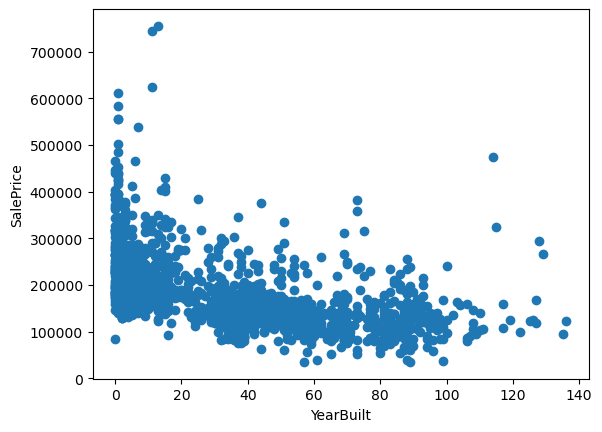

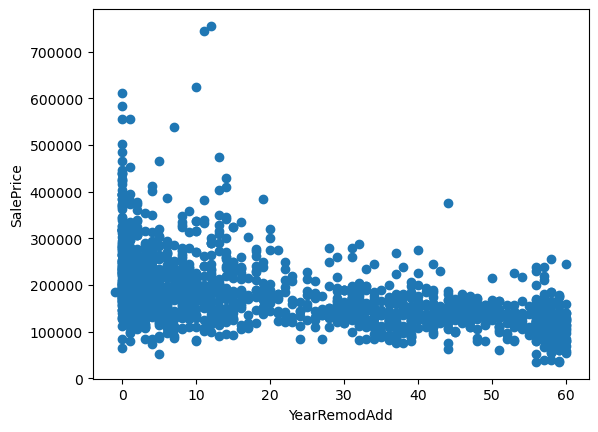

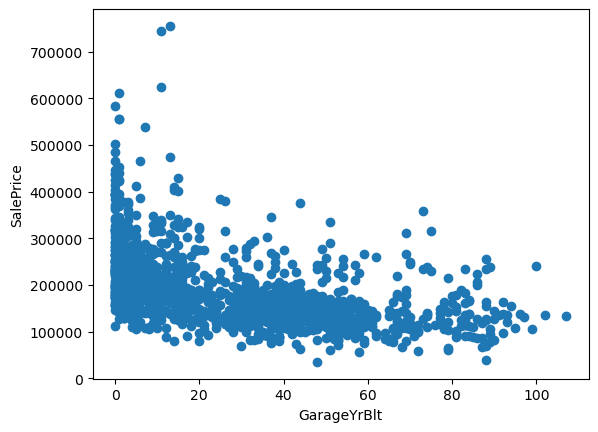

In [18]:
def analyze_yr_vars(df, var):
    df = df.copy()
    df[var] = df["YrSold"] - df[var]
    plt.scatter(df[var], df["SalePrice"])
    plt.ylabel("SalePrice")
    plt.xlabel(var)
    plt.show()

for var in year_vars:
    if var != "YrSold":
        analyze_yr_vars(data, var)

above plot shows the trend of SalePrice before the year in which it was sold , all of which show a general downward trend

**Discrete variables**
separating discrete and continous variables using a pre-determined parameter for number of unique values

In [19]:
discrete_vars = [var for var in num_vars if len(data[var].unique()) < 20 and var not in year_vars]
print("number of discrete variables : ", len(discrete_vars))

number of discrete variables :  13


In [20]:
data[discrete_vars].head()

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold
0,7,5,1,0,2,1,3,1,8,0,2,0,2
1,6,8,0,1,2,0,3,1,6,1,2,0,5
2,7,5,1,0,2,1,3,1,6,1,2,0,9
3,7,5,1,0,1,0,3,1,7,1,3,0,2
4,8,5,1,0,2,1,4,1,9,1,3,0,12


In [21]:
#plotting these discrete fields against target variable

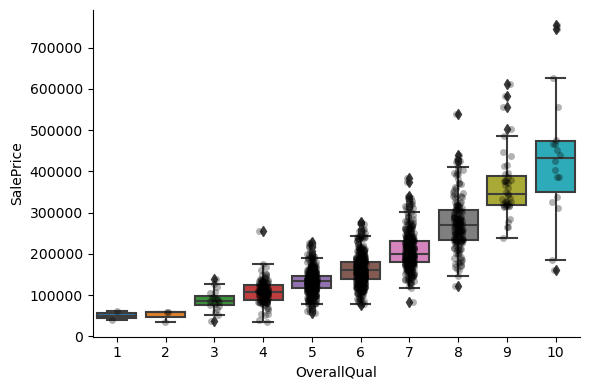

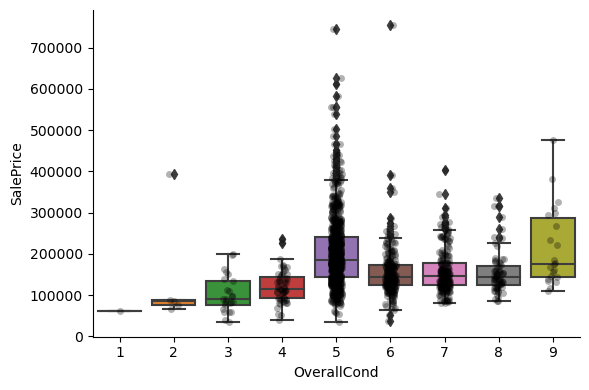

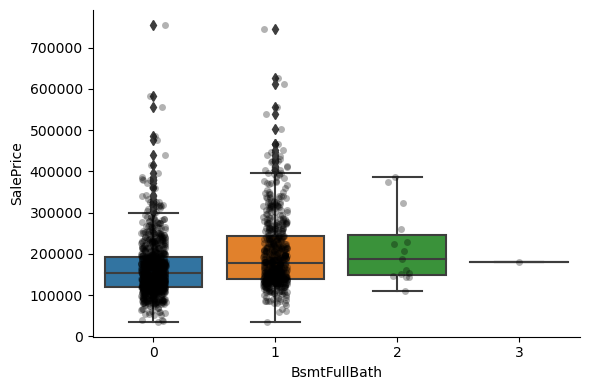

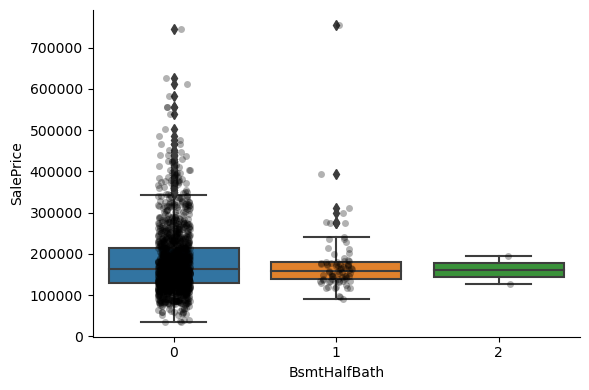

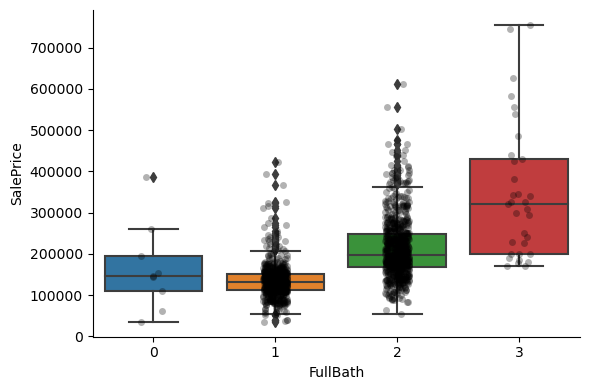

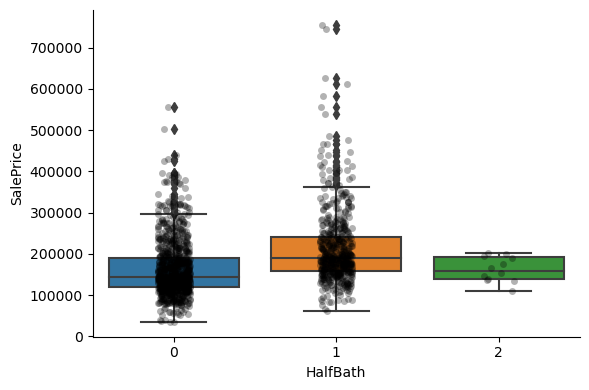

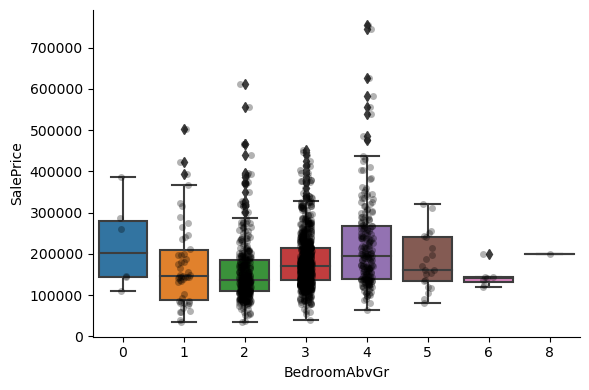

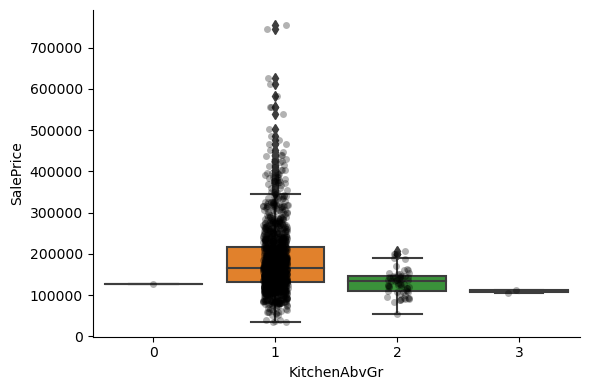

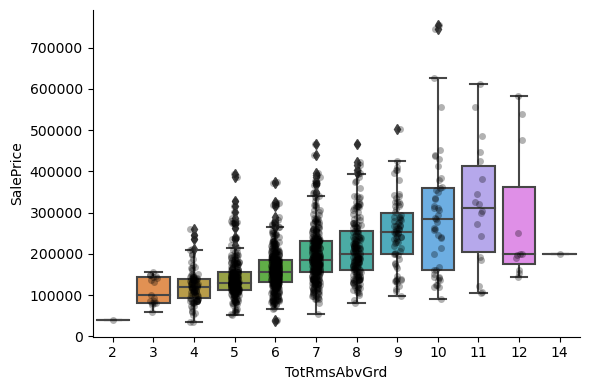

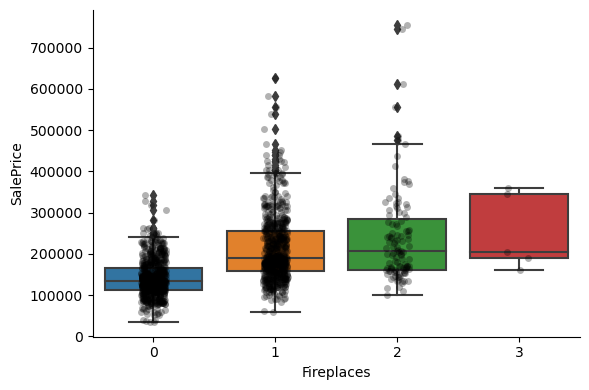

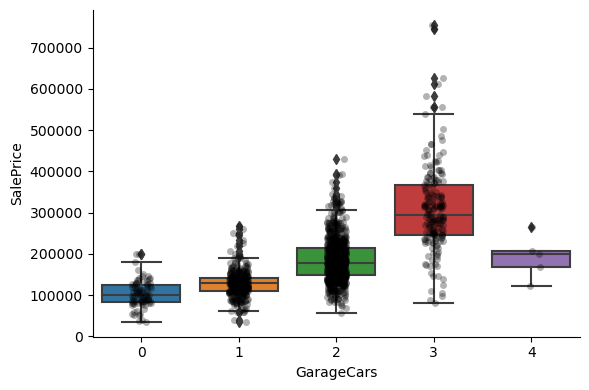

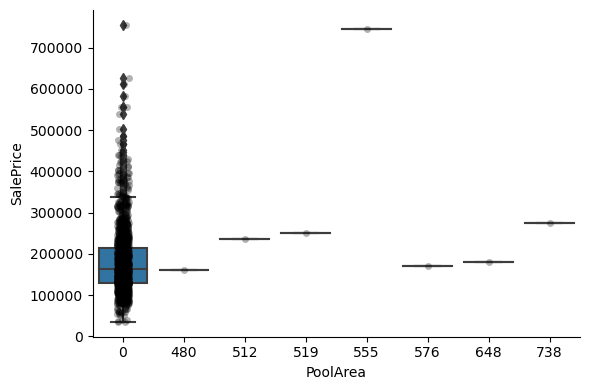

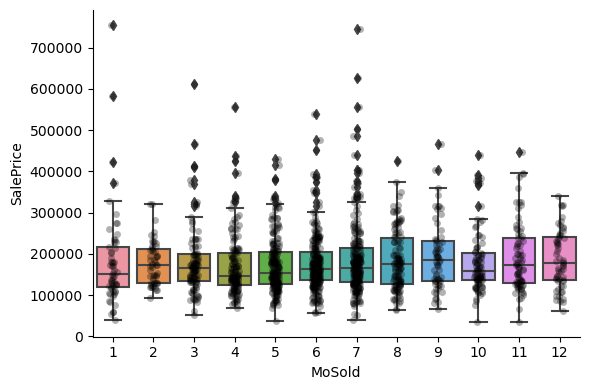

In [22]:
for var in discrete_vars:
    sns.catplot(x=var, y="SalePrice", data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y="SalePrice", data=data, jitter=0.1, alpha=0.3, color="k")
    plt.show()

**Continuous variables**

In [23]:
cont_vars = [var for var in num_vars if var not in discrete_vars+year_vars]
print("continous variable: # ", len(cont_vars))

continous variable: #  18


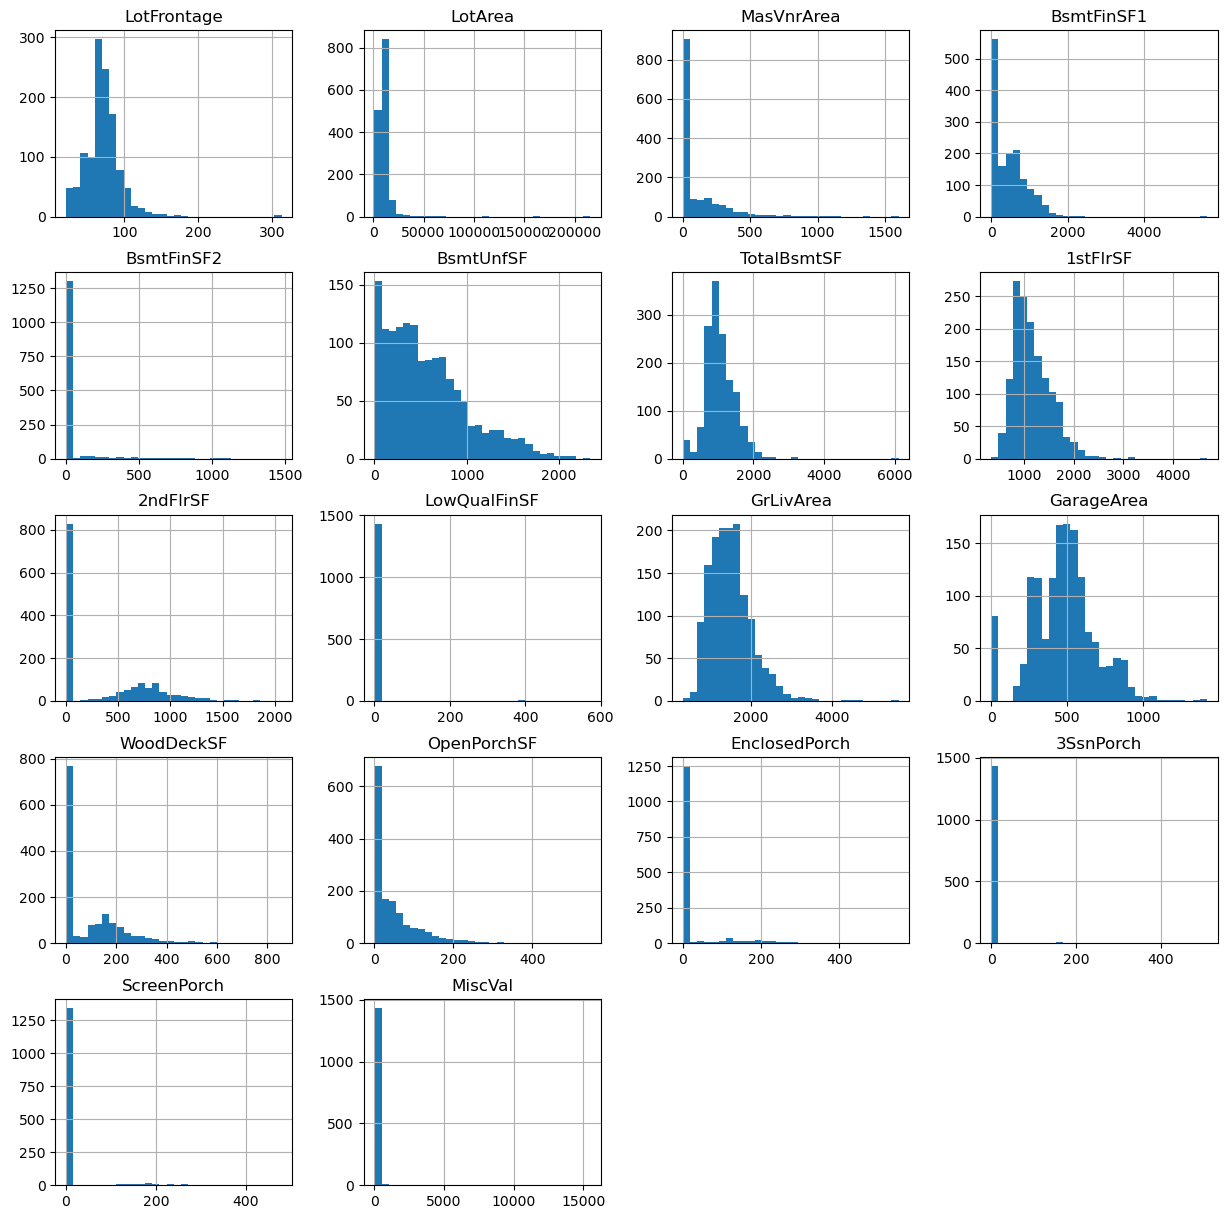

In [24]:
data[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

**seggregating continuous fields and negatively skewed fields**

In [25]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]
cont_vars = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
]

Yeo-Johnson transformation (using scipy library) is used for reducing the skewness of the data 

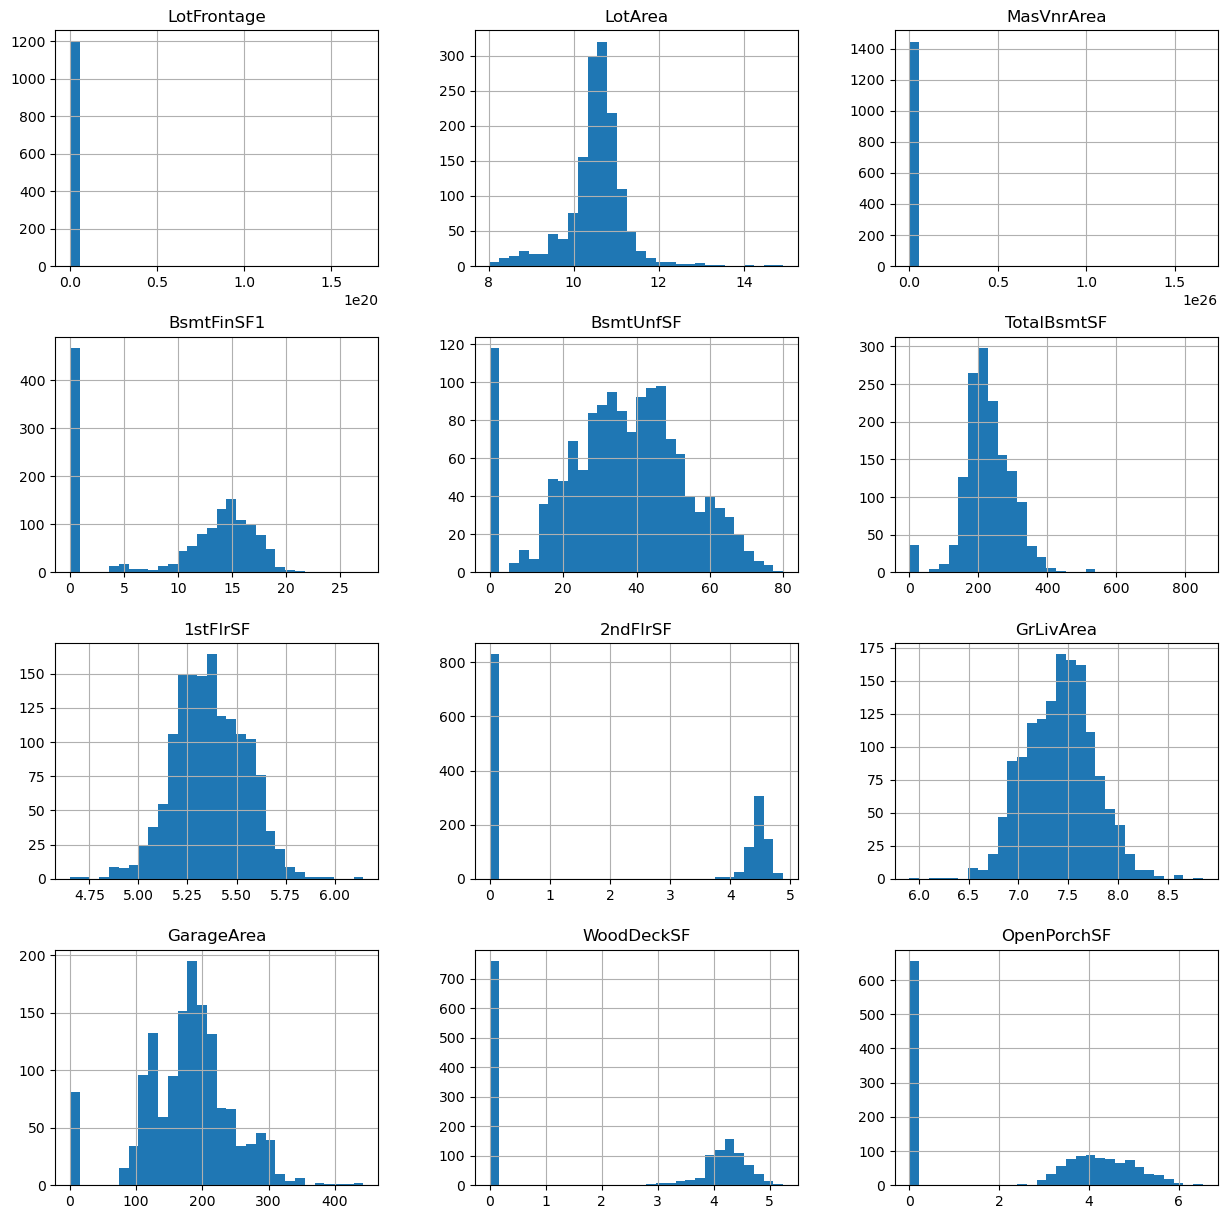

In [26]:
#yeo-johnson transformation
tmp = data.copy()
for var in cont_vars:
    tmp[var], param = stats.yeojohnson(data[var])

tmp[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

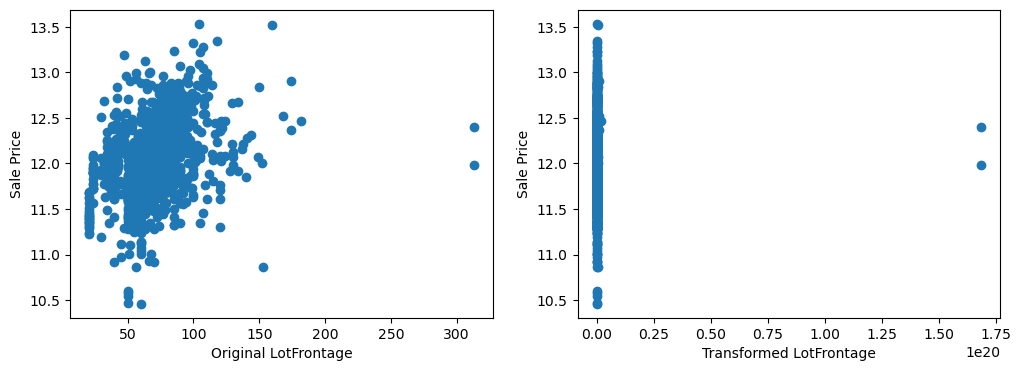

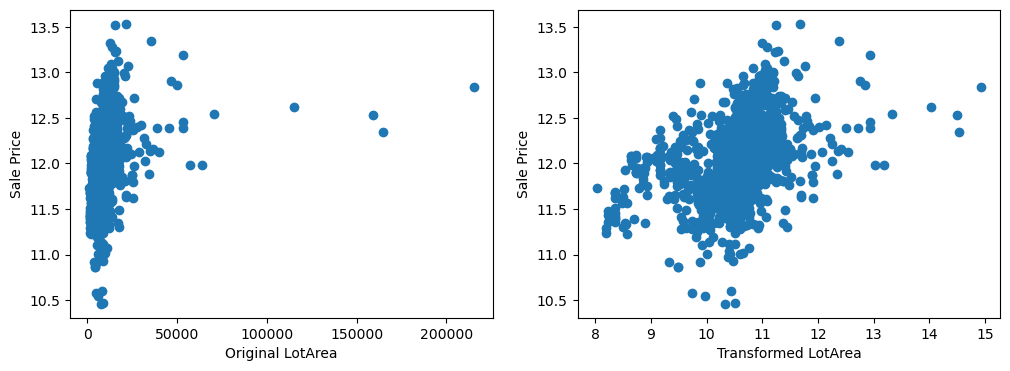

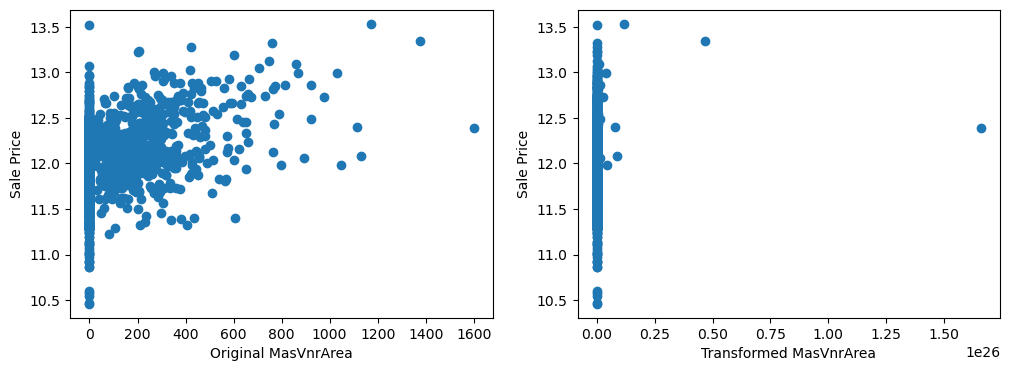

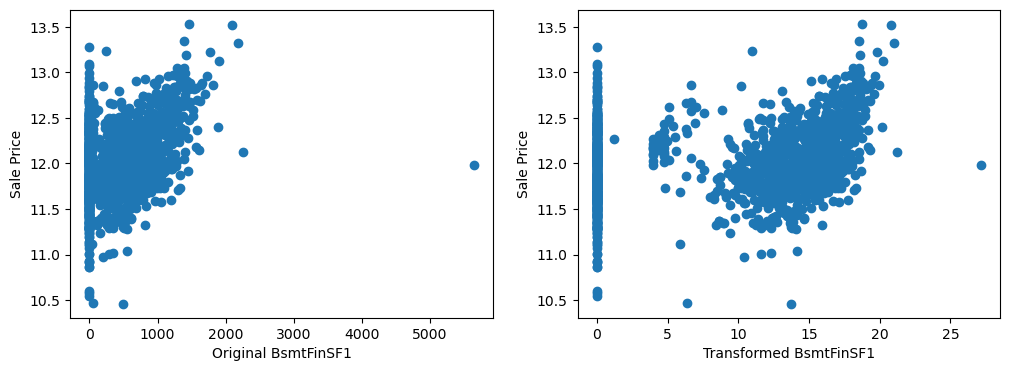

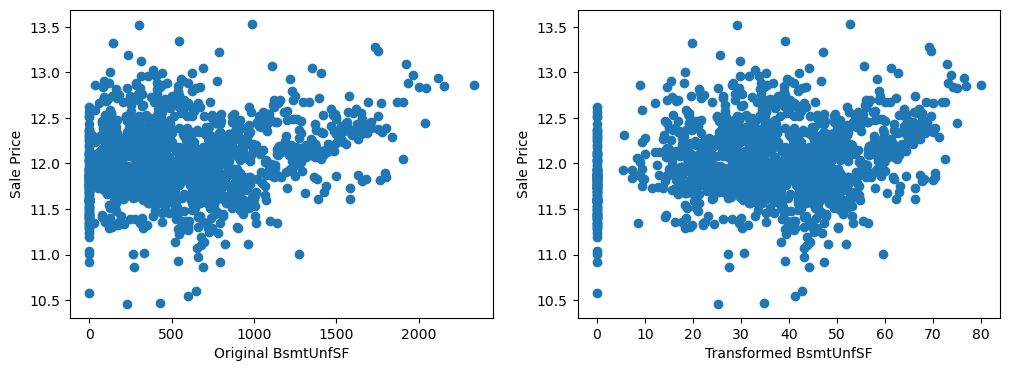

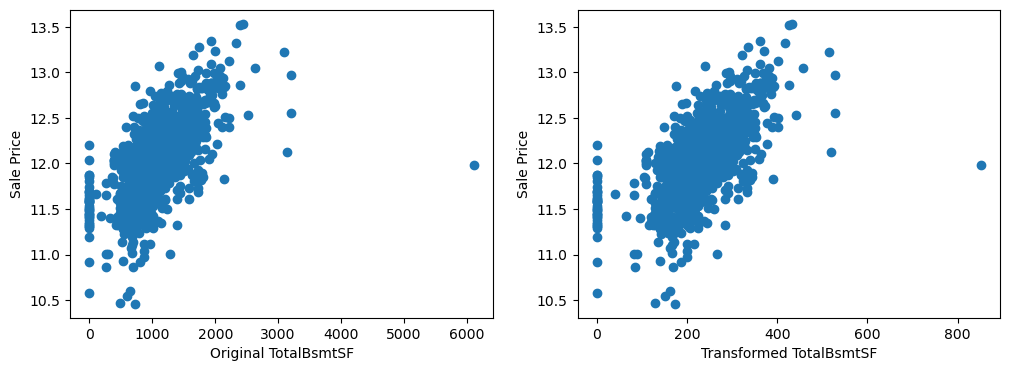

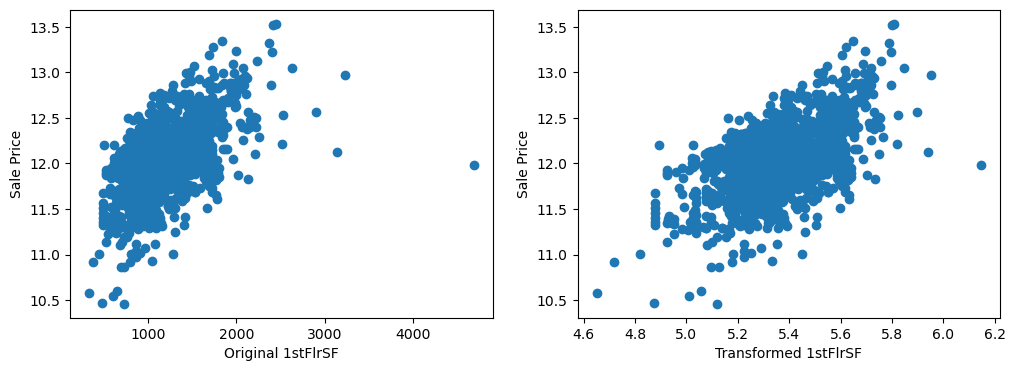

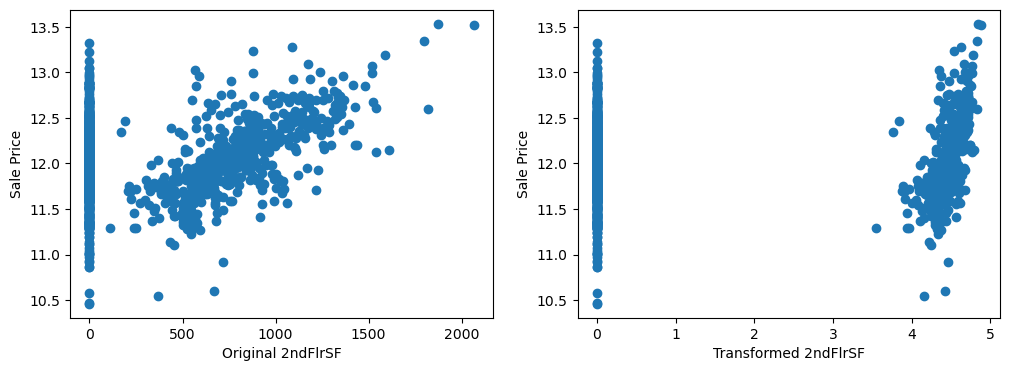

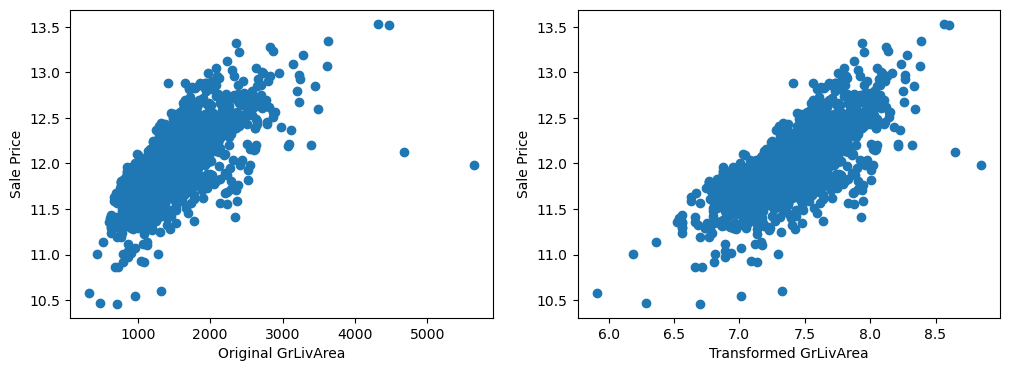

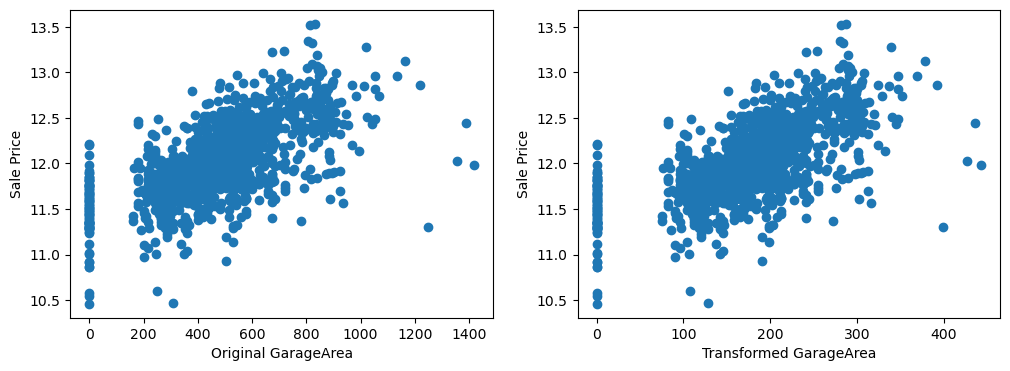

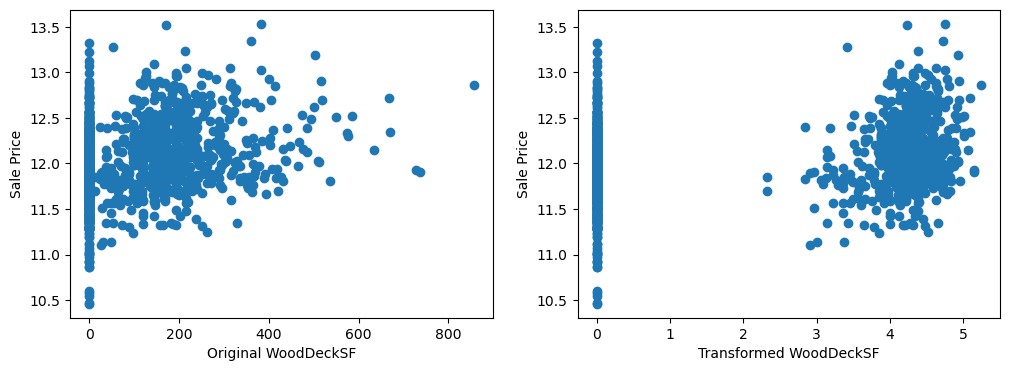

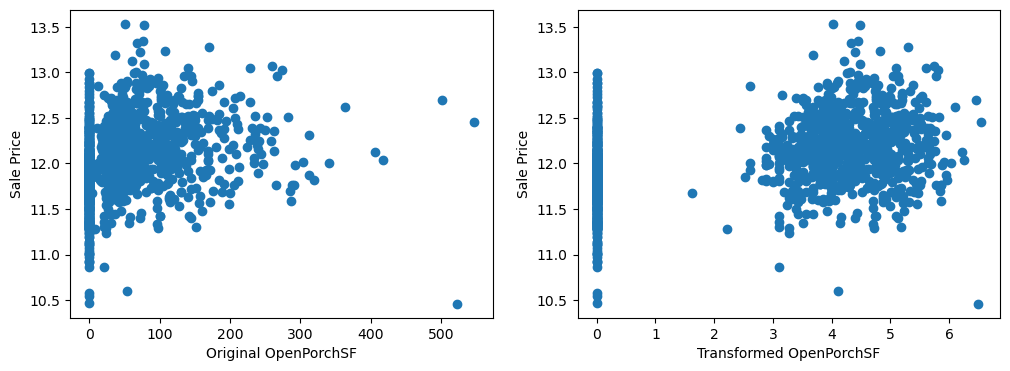

In [27]:
#plotting original and transformed continuous variables

for var in cont_vars:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(data[var], np.log(data['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

Logarithmic transformation for handling right skewed data 

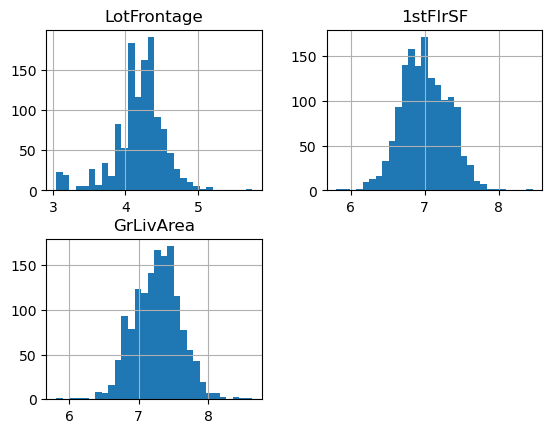

In [28]:
tmp = data.copy()
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    tmp[var] = np.log(data[var])

tmp[["LotFrontage", "1stFlrSF", "GrLivArea"]].hist(bins=30)
plt.show()

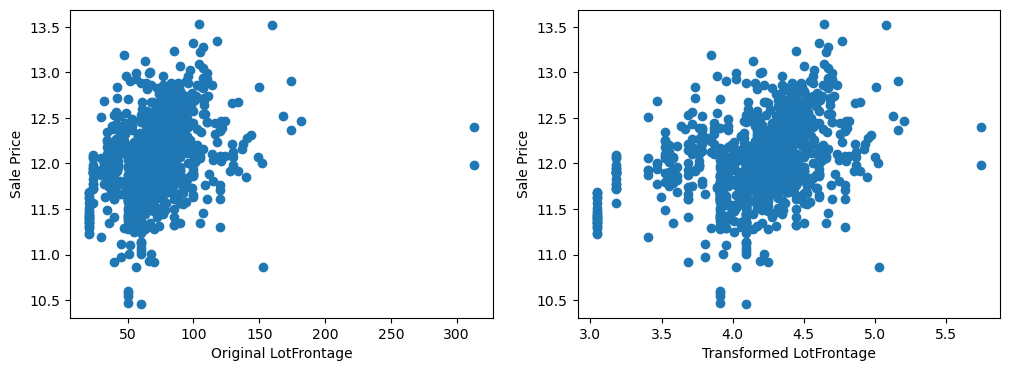

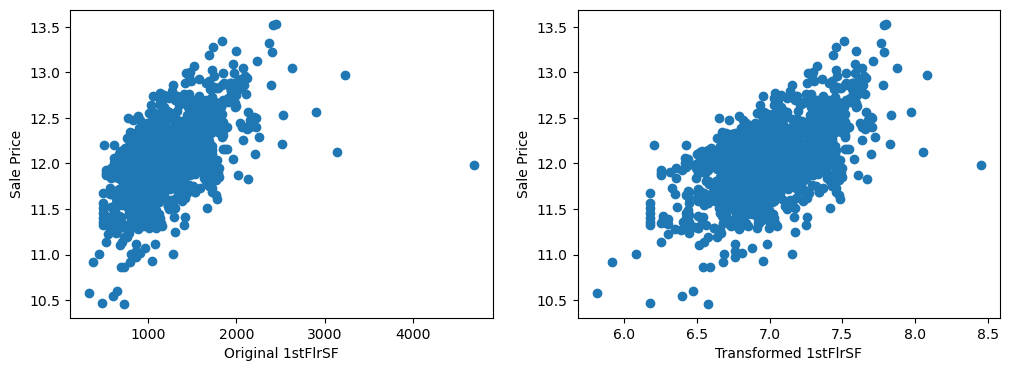

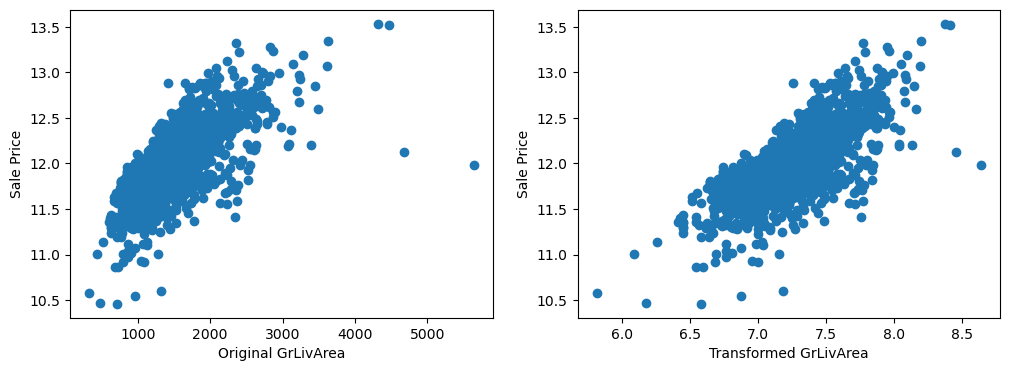

In [29]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    
    plt.figure(figsize=(12,4))   
    plt.subplot(1, 2, 1)
    plt.scatter(data[var], np.log(data['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)
    
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

**skewed field analysis against target variable**

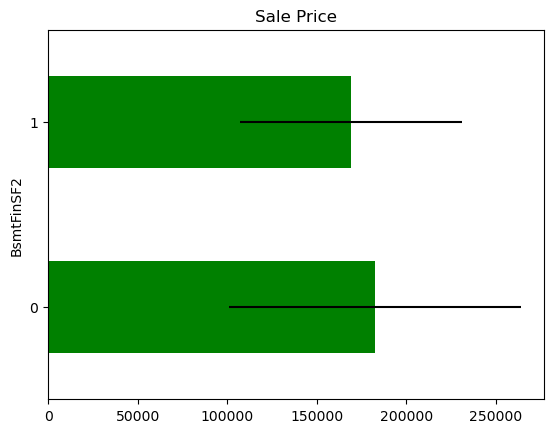

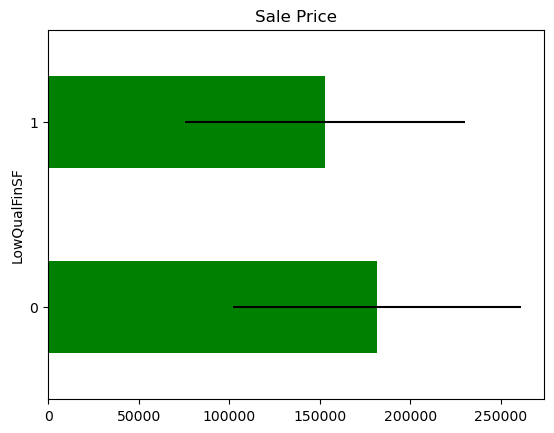

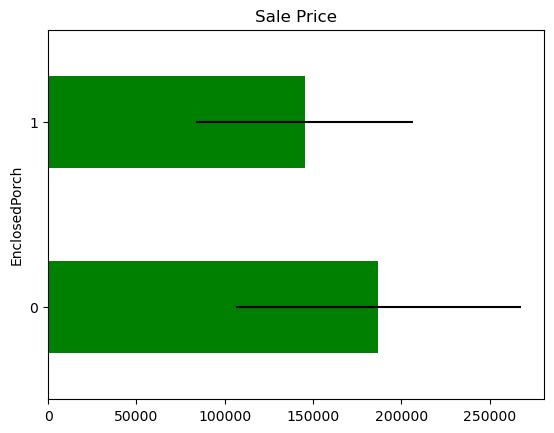

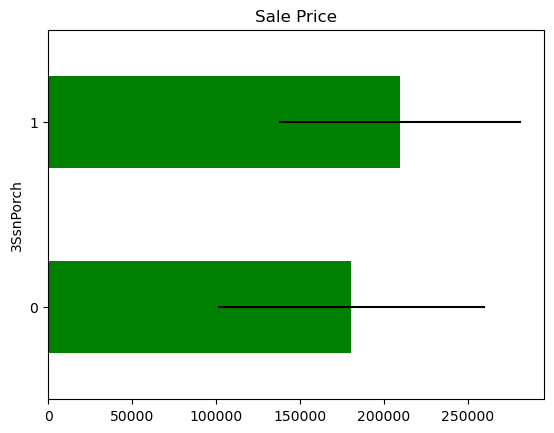

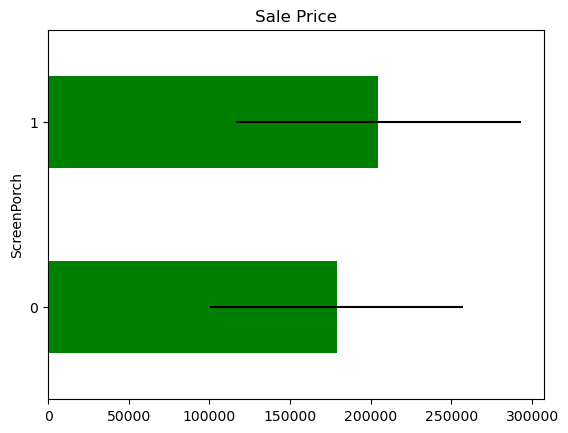

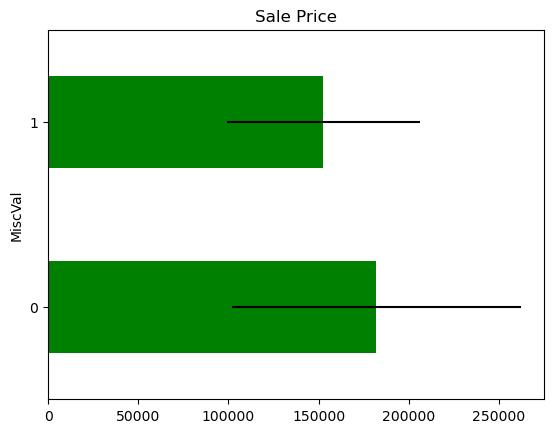

In [30]:
for var in skewed:
    tmp = data.copy()
    tmp[var] = np.where(data[var]==0, 0, 1)
    tmp = tmp.groupby(var)["SalePrice"].agg(["mean", "std"])

    tmp.plot(kind="barh", y="mean", legend=False, xerr="std", title="Sale Price", color="green")
    plt.show()

**Categorical field analysis**

In [31]:
len(cat_vars)

44

<Axes: >

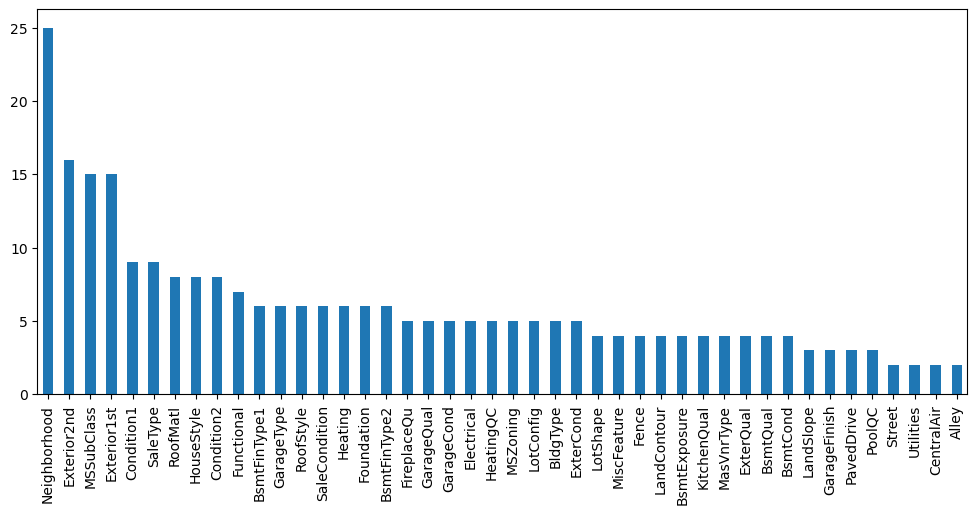

In [32]:
#printing number of unique values for each field
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12, 5))

***PREPROCESSING***

For preprocessing , we will concatenate test and train data to make it easier to handle missing values.

In [33]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_id = test['Id']

In [34]:
f_data = pd.concat([data,test], axis=0)
y_train = data['SalePrice']
f_data = f_data.drop(['Id', 'SalePrice'], axis=1)
print(f_data.shape)

(2919, 79)


Mapping of qua;lity variables for regression analysis

In [35]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    f_data[var] = f_data[var].map(qual_mappings)

exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'Missing': 0, 'NA': 0}

var = 'BsmtExposure'

f_data[var] = f_data[var].map(exposure_mappings)

finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    f_data[var] = f_data[var].map(finish_mappings)

garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

f_data[var] = f_data[var].map(garage_mappings)

fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

f_data[var] = f_data[var].map(fence_mappings)

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']


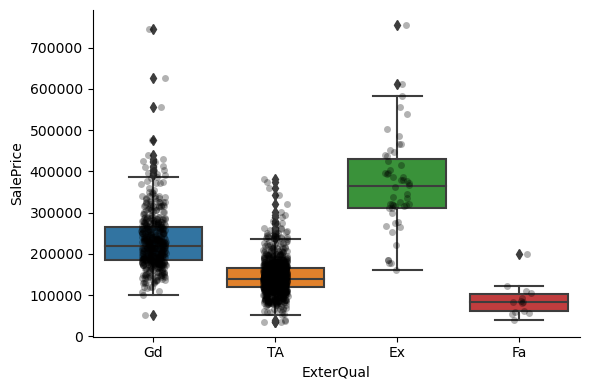

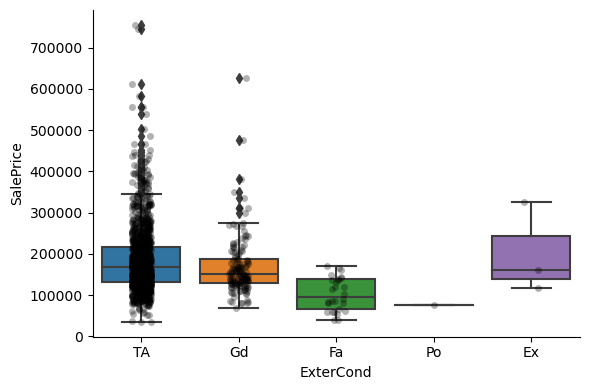

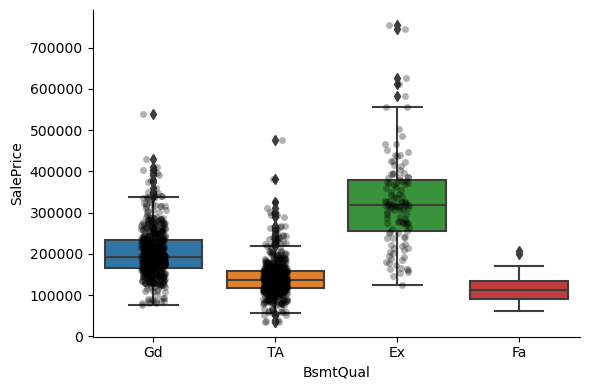

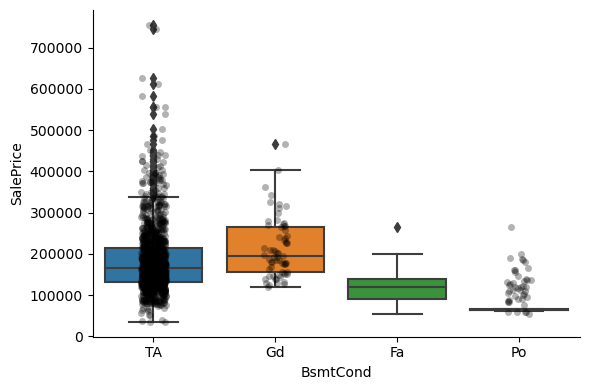

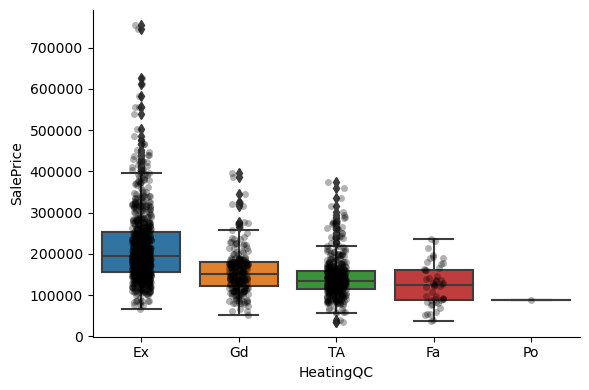

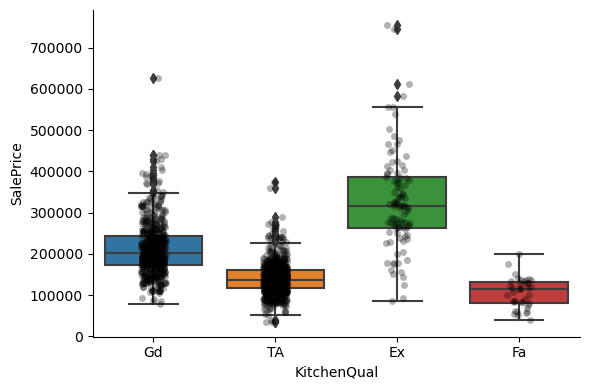

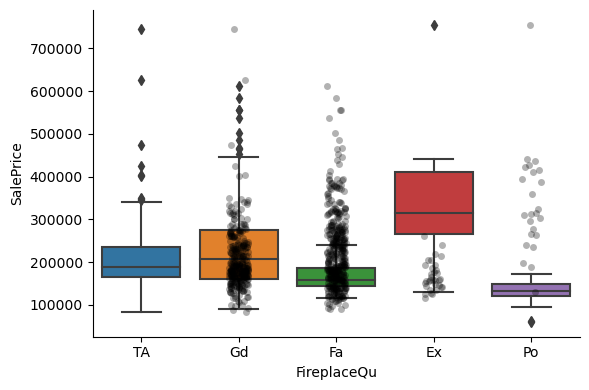

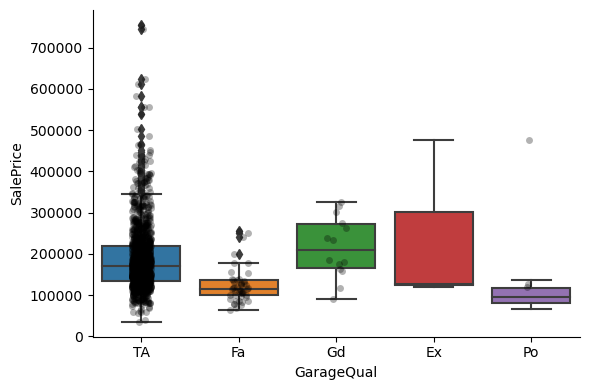

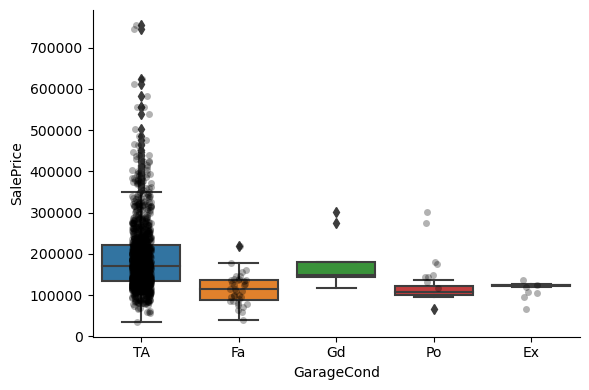

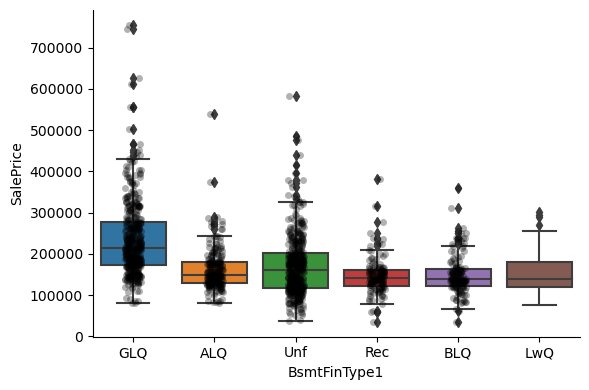

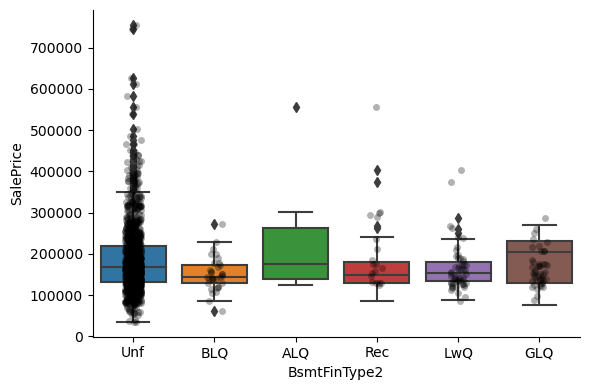

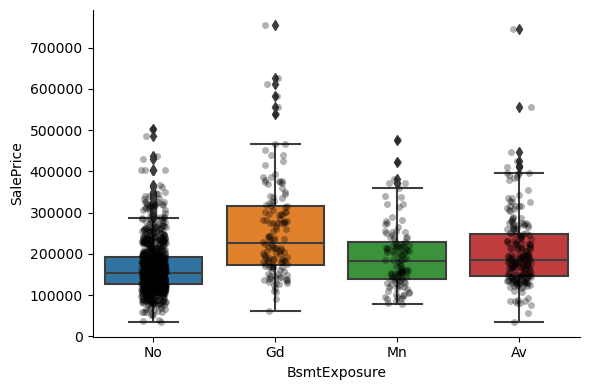

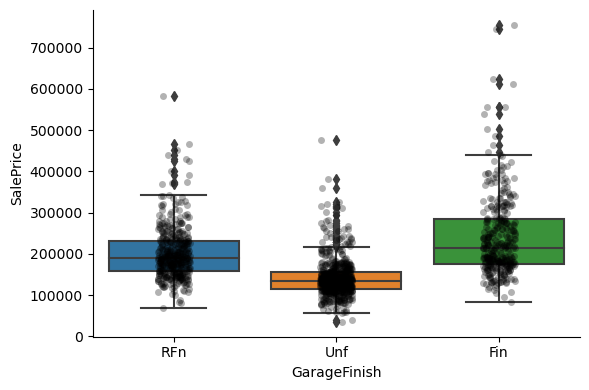

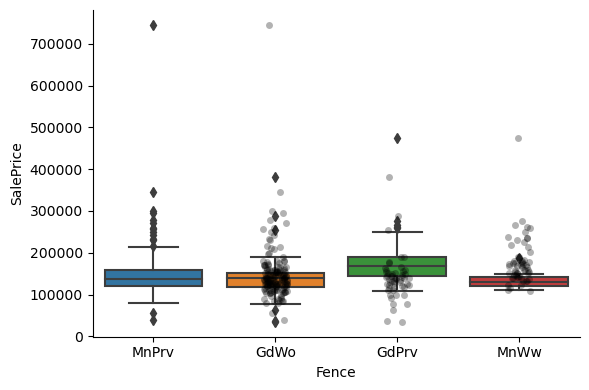

In [36]:
for var in qual_vars:
    sns.catplot(x=var, y='SalePrice', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()

Dropping skewed columns from the data

In [37]:
for var in skewed:
    f_data.drop(var,axis=1, inplace=True)

In [38]:
print(f_data.shape)

(2919, 73)


Dropping Quality variables with high and varied concentration of datapoints for a particular x val.

In [39]:
qual_drops = ['GarageCond','GarageQual','BsmtCond','ExterCond']
for var in qual_drops:
    f_data.drop(var,axis=1, inplace=True)

****

In [40]:
f_data.drop('Utilities',axis=1,inplace=True)

In [41]:
print(f_data.shape)

(2919, 68)


In [42]:
f_data.isnull().sum().sort_values(ascending = False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
                 ... 
Foundation          0
HeatingQC           0
CentralAir          0
1stFlrSF            0
SaleCondition       0
Length: 68, dtype: int64

In [43]:
for var in f_data.columns:
  if f_data[var].isnull().sum() > 5:
    f_data.drop(var , axis = 1 , inplace= True)

In [44]:
print(f_data.shape)

(2919, 53)


In [45]:
total = f_data.isnull().sum().sort_values(ascending=False)
total.head(20)

MSZoning        4
BsmtHalfBath    2
Functional      2
BsmtFullBath    2
Electrical      1
GarageArea      1
Exterior2nd     1
KitchenQual     1
GarageCars      1
BsmtFinSF1      1
BsmtUnfSF       1
TotalBsmtSF     1
SaleType        1
Exterior1st     1
FullBath        0
GrLivArea       0
2ndFlrSF        0
MSSubClass      0
HalfBath        0
BedroomAbvGr    0
dtype: int64

In [46]:
#Filling the numeric data with 0 for null values
numeric_missed = ['BsmtFinSF1',
'BsmtUnfSF',
'TotalBsmtSF',
'BsmtFullBath',
'BsmtHalfBath',
'GarageArea',
'GarageCars']
for feature in numeric_missed:
    f_data[feature] = f_data[feature].fillna(0)
#Filling the categorical data with mode value for missing value
categorical_missed = ['Exterior1st',
'Exterior2nd',
'SaleType',
'MSZoning',
'Electrical',
'KitchenQual',
'Functional']
for feature in categorical_missed:
    f_data[feature] = f_data[feature].fillna(f_data[feature].mode()[0])

In [47]:
#Checking for any remaining null values
f_data.isnull().sum().max()

0

Converting categorical data to numerical

In [48]:
f_data = pd.get_dummies(f_data)
f_data.head()

/tmp/ipykernel_20/1509088520.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  f_data = pd.get_dummies(f_data)


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,8450,7,5,2003,2003,4,706.0,150.0,856.0,5,...,0,0,0,1,0,0,0,0,1,0
1,9600,6,8,1976,1976,3,978.0,284.0,1262.0,5,...,0,0,0,1,0,0,0,0,1,0
2,11250,7,5,2001,2002,4,486.0,434.0,920.0,5,...,0,0,0,1,0,0,0,0,1,0
3,9550,7,5,1915,1970,3,216.0,540.0,756.0,4,...,0,0,0,1,1,0,0,0,0,0
4,14260,8,5,2000,2000,4,655.0,490.0,1145.0,5,...,0,0,0,1,0,0,0,0,1,0


In [49]:
#Dividing data back into train & test
train =f_data[:len(y_train)]
test = f_data[len(y_train):]
#Printing thier shapes
print(train.shape, test.shape)

(1460, 212) (1459, 212)


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [51]:
print(len(y_train))

1460


In [52]:
x__train, x__test, y__train, y__test = train_test_split(train, y_train, test_size=0.2, random_state=42)

In [53]:
clf = RandomForestRegressor(n_estimators=300)

In [54]:
clf.fit(x__train, y__train)

RandomForestRegressor(n_estimators=300)

In [55]:
clf.score(x__test,y__test)

0.8980773059929429

In [56]:
#Making an prediction
prediction = clf.predict(test)
print(prediction)

[127448.84333333 158271.78333333 175732.40666667 ... 161808.82666667
 118236.         225482.56333333]


In [57]:
print(len(prediction))
print(len(test_id))

1459
1459


In [58]:
type(prediction)


numpy.ndarray

In [59]:
type(test_id)

pandas.core.series.Series

In [60]:
prediction_df = pd.DataFrame({'Prediction': prediction.flatten()})

In [61]:
id_df = pd.DataFrame({'id': test_id})


In [62]:
result_df = pd.merge(id_df, prediction_df, left_index=True, right_index=True)


In [63]:
result_df.to_csv('predictions_with_id.csv', index=False)
